<h3>Data preparation</h3>

In [2]:
from bs4 import BeautifulSoup
import requests
import pandas as pd

In [3]:
# URL of the Friends episode transcript
url = "https://fangj.github.io/friends/season/0101.html" 

# Send an HTTP GET request to fetch the webpage content
response = requests.get(url)

# Parse the HTML content using BeautifulSoup
soup = BeautifulSoup(response.text, "html.parser") 

In [4]:
from collections import defaultdict

# A default dict is used to store interaction counts. The defaylt value is 0 for missing keys
interactions = defaultdict(int)

previous_speaker = None
speaker = None

# Function to split a string with multiple speakers (e.g. "Monica and Rachel")
def split_speaker(speaker):
    return [s.strip() for s in speaker.split(" and ")]

# Iterate over all <p> tags
for p in soup.find_all("p"):
    # Look for a bold tag to identify the speaker
    bold_tag = p.find("b")
    if bold_tag:
        speaker = bold_tag.get_text(strip=True).replace(":", "")
        # Split the speaker string if there's more than one
        speakers = split_speaker(speaker)
    else:
        speakers = []

    if previous_speaker and speakers:
        for s in speakers:
            # Check if the speaker is not a special case
            if previous_speaker not in ["All", "Closing Credits", "Commercial Break", s] and s not in ["All", "Closing Credits", "Commercial Break"]:
                interactions[(previous_speaker, s)] += 1

    previous_speaker = speakers[-1] if speakers else previous_speaker

interactions

defaultdict(int,
            {('Monica', 'Joey'): 9,
             ('Joey', 'Chandler'): 12,
             ('Chandler', 'Phoebe'): 1,
             ('Phoebe', 'Monica'): 7,
             ('Monica', 'Chandler'): 4,
             ('Chandler', 'Joey'): 12,
             ('Joey', 'Phoebe'): 3,
             ('Phoebe', 'Chandler'): 2,
             ('Chandler', 'Monica'): 7,
             ('Chandler', 'Ross'): 6,
             ('Ross', 'Joey'): 9,
             ('Joey', 'Monica'): 9,
             ('Monica', 'Ross'): 14,
             ('Ross', 'Chandler'): 7,
             ('Ross', 'Phoebe'): 4,
             ('Phoebe', 'Ross'): 4,
             ('Ross', 'Monica'): 10,
             ('Joey', 'Ross'): 7,
             ('Monica', 'Rachel'): 20,
             ('Rachel', 'Monica'): 18,
             ('Rachel', 'Ross'): 16,
             ('Ross', 'Rachel'): 13,
             ('Rachel', 'Phoebe'): 4,
             ('Joey', 'Rachel'): 5,
             ('Monica', 'Phoebe'): 5,
             ('Phoebe', 'Rachel'): 2,
       

In [5]:
# New dictonary that contains interaction counts, with speaker pairs treated as unoriented
unoriented_interactions = defaultdict(int)

for (s1, s2), count in interactions.items():
    # Sort the tuple of speakers to ensure the order of speakers does not matter
    key = tuple(sorted([s1, s2]))
    unoriented_interactions[key] += count

unoriented_interactions

defaultdict(int,
            {('Joey', 'Monica'): 18,
             ('Chandler', 'Joey'): 24,
             ('Chandler', 'Phoebe'): 3,
             ('Monica', 'Phoebe'): 12,
             ('Chandler', 'Monica'): 11,
             ('Joey', 'Phoebe'): 4,
             ('Chandler', 'Ross'): 13,
             ('Joey', 'Ross'): 16,
             ('Monica', 'Ross'): 24,
             ('Phoebe', 'Ross'): 8,
             ('Monica', 'Rachel'): 38,
             ('Rachel', 'Ross'): 29,
             ('Phoebe', 'Rachel'): 6,
             ('Joey', 'Rachel'): 6,
             ('Chandler', 'Paul'): 3,
             ('Monica', 'Paul'): 26,
             ('Joey', 'Paul'): 4,
             ('Chandler', 'Rachel'): 13,
             ('Frannie', 'Rachel'): 1,
             ('Frannie', 'Monica'): 8,
             ('Frannie', 'Joey'): 1})

In [6]:
# Store dictionary as csv file
import csv

with open("interactions.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["Character1", "Character2", "InteractionCount"]) # Header
    for (char1, char2), count in unoriented_interactions.items():
        writer.writerow([char1, char2, count])

<h3>Create graph</h3>

In [7]:
import networkx as nx
import matplotlib.pyplot as plt

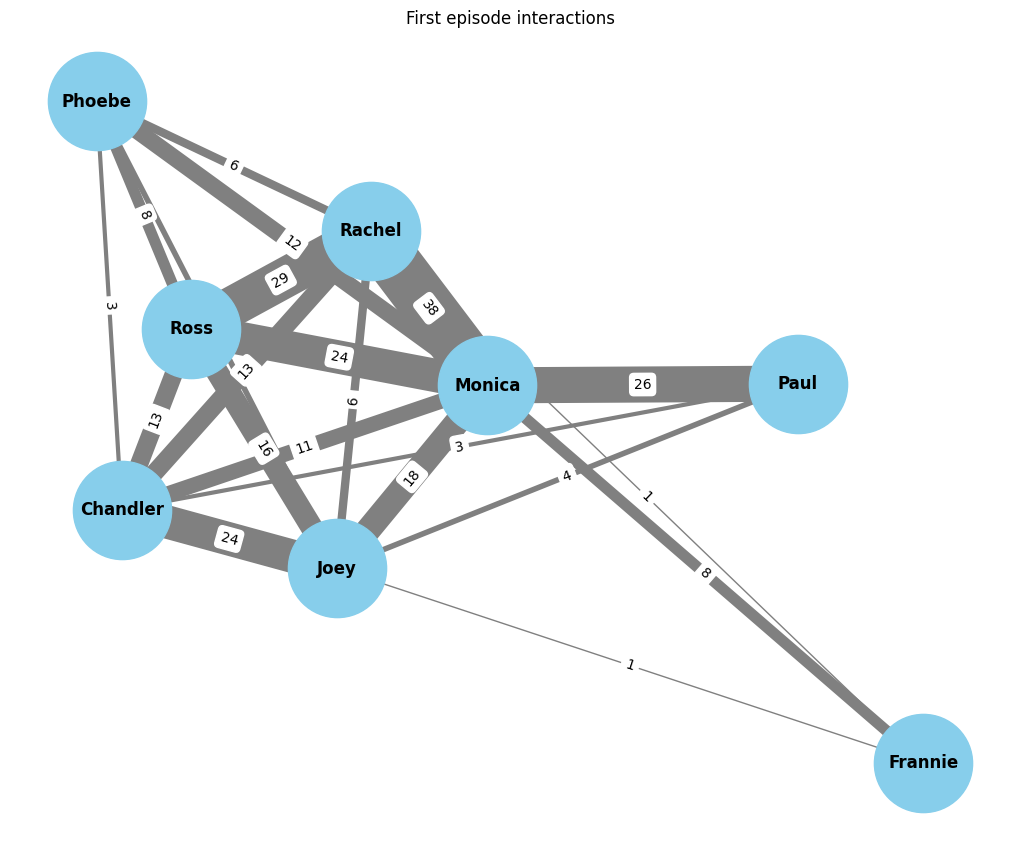

In [8]:
G = nx.Graph()

for (s1, s2), count in unoriented_interactions.items():
    G.add_edge(s1, s2, weight=count)

plt.figure(figsize=(10,8))

edge_weights = [d["weight"] for _, _, d in G.edges(data=True)]

pos = nx.spring_layout(G, weight='weight', seed=42)

nx.draw(G, pos, with_labels=True, node_size=5000, node_color="skyblue", font_size=12, font_weight="bold", edge_color="gray", width=edge_weights)

edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title("First episode interactions")
plt.show()

<h3>Metrics</h3>

In [9]:
print(G)

Graph with 8 nodes and 21 edges


In [10]:
density = nx.density(G)
print(f"Graph density: {density}")

Graph density: 0.75


Density is the ratio of actual edges in the network to all possible edges in the network. It provides a quick sense of how closely knit the network is. 
This graph has a density of 0.75, meaning that 75% of all possible edges are present. Additionally, graph is <b>well-connected</b> - almost everyone interacts with almost everyone else, and there are only a few isolated nodes. This is understandable because there are two characters aside from the six m

<h2>Data from 1 Season</h2>

In [11]:
base_url = "https://fangj.github.io/friends/"

response = requests.get(base_url)
soup = BeautifulSoup(response.text, "html.parser")

episode_links = []
for link in soup.find_all("a"):
    href = link.get("href")
    if href and href.startswith("season/01"):
        episode_links.append(base_url + href)

data = []

for episode_url in episode_links:
    episode_response = requests.get(episode_url)
    episode_soup = BeautifulSoup(episode_response.text, "html.parser")
    data.append([episode_url[-7:-5],episode_soup])

df = pd.DataFrame(data, columns=["Episode", "Dialogue"])

In [12]:
interactions_season_1 = defaultdict(int)

previous_speaker = None
speaker = None

special_cases = ["All", "Closing Credits", "Commercial Break", "Commercial break", "Opening Credits", "The Whole Party", "Both", "", "Girls", "his"]

for episode_dialogue in df["Dialogue"]:
    for p in episode_dialogue.find_all("p"):
        bold_tag = p.find("b")
        if bold_tag:
            speaker = bold_tag.get_text(strip=True).replace(":", "")
            speakers = split_speaker(speaker)
        else:
            speakers = []

        if previous_speaker and speakers:
            for s in speakers:
                if previous_speaker not in special_cases and previous_speaker != s and s not in special_cases:
                    interactions_season_1[(previous_speaker, s)] += 1

        previous_speaker = speakers[-1] if speakers else previous_speaker

In [13]:
len(interactions_season_1)

418

In [14]:
unoriented_interactions_season_1 = defaultdict(int)

for (s1, s2), count in interactions_season_1.items():
    key = tuple(sorted([s1, s2]))
    unoriented_interactions_season_1[key] += count
    print(s1, s2, count)

Monica Joey 106
Joey Chandler 167
Chandler Phoebe 105
Phoebe Monica 132
Monica Chandler 80
Chandler Joey 149
Joey Phoebe 51
Phoebe Chandler 110
Chandler Monica 106
Chandler Ross 134
Ross Joey 140
Joey Monica 96
Monica Ross 118
Ross Chandler 144
Ross Phoebe 76
Phoebe Ross 77
Ross Monica 103
Joey Ross 146
Monica Rachel 219
Rachel Monica 218
Rachel Ross 192
Ross Rachel 203
Rachel Phoebe 102
Joey Rachel 39
Monica Phoebe 143
Phoebe Rachel 106
Chandler Paul 3
Paul Monica 14
Phoebe Joey 47
Joey Paul 1
Paul Joey 3
Chandler Rachel 95
Monica Paul 12
Rachel Chandler 91
Rachel Joey 49
Rachel Frannie 1
Frannie Monica 4
Monica Frannie 4
Frannie Joey 1
Ross Marsha 4
Marsha Ross 4
Ross Carol 43
Carol Ross 48
Joey Mrs. Geller 1
Mrs. Geller Monica 18
Monica Mrs. Geller 19
Mrs. Geller Ross 9
Ross Mr. Geller 4
Mr. Geller Mrs. Geller 2
Ross Mrs. Geller 6
Mrs. Geller Mr. Geller 2
Monica Mr. Geller 6
Mr. Geller Monica 6
Ross Susan 46
Susan Carol 13
Susan Ross 39
Carol Rachel 5
Rachel Barry 22
Barry Rachel 26

In [15]:
len(unoriented_interactions_season_1)

264

In [16]:
with open("interactions_season_1.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["Character1", "Character2", "InteractionCount"])
    for (char1, char2), count in unoriented_interactions_season_1.items():
        writer.writerow([char1, char2, count])

<h3>Create Graph for Season 1</h3>

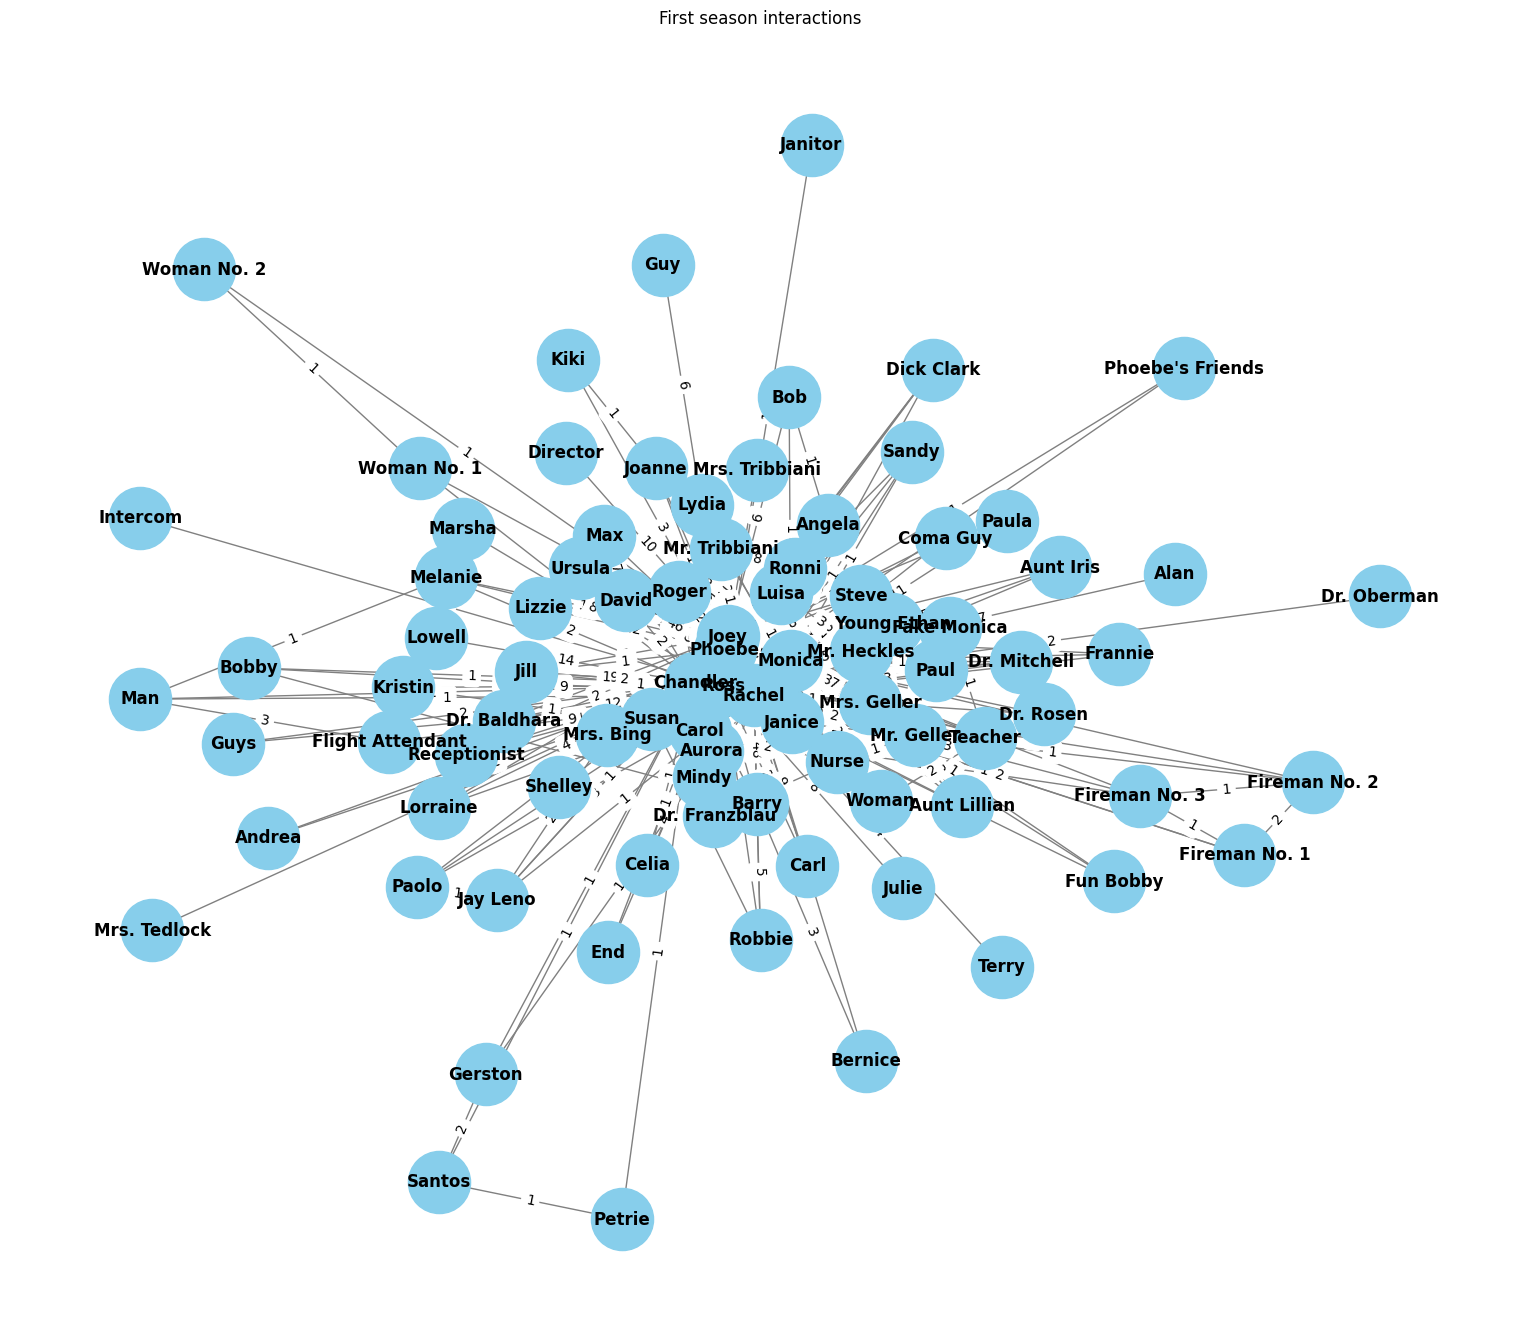

In [20]:
G = nx.Graph()

for (s1, s2), count in unoriented_interactions_season_1.items():
    G.add_edge(s1, s2, weight=count)

plt.figure(figsize=(15,13))

pos = nx.spring_layout(G, seed=42)

nx.draw(G, pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=12, font_weight="bold", edge_color="gray")

edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title("First season interactions")
plt.show()